In [252]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor, plot_importance, DMatrix

# parameter tuning
from itertools import product
from collections import OrderedDict, defaultdict
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [363]:
plt.rcParams.update({'font.size': 22})

In [364]:
market_area = 'atlanta'

In [365]:
ct_stats_df = pd.read_csv(f'{market_area}_census_tract_data_removed_redundant_features.csv')

In [366]:
ct_stats_df.shape

(630, 95)

In [367]:
np.corrcoef(ct_stats_df['built 1995 or later'], ct_stats_df['linear_pop_trend_since_2010'])[1, 0]

0.41933868124168294

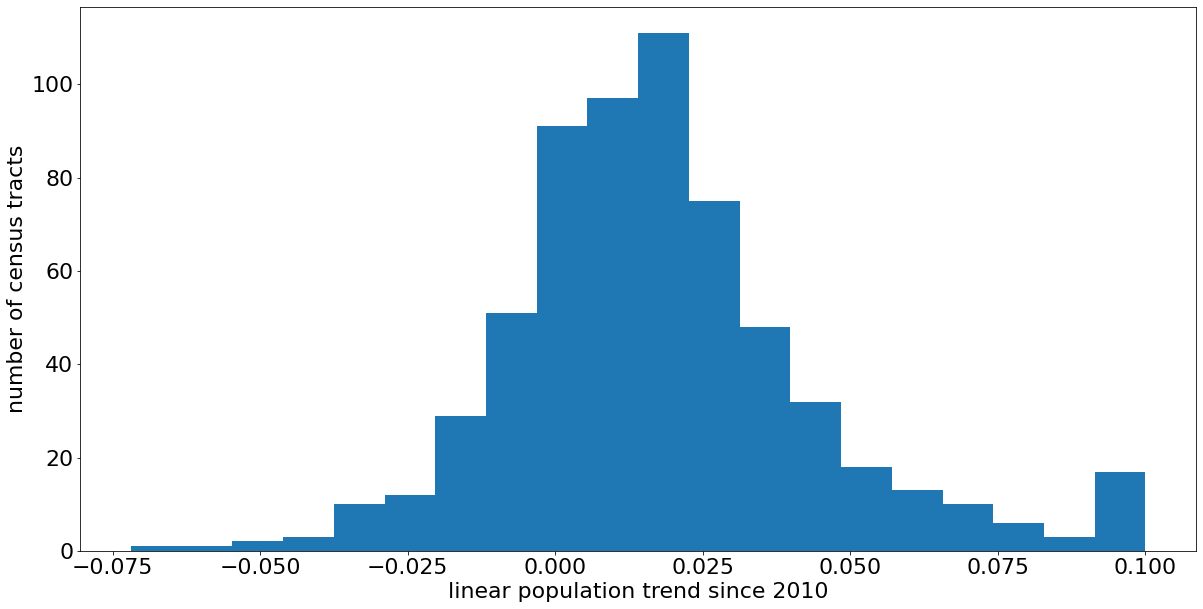

In [368]:
plt.figure(figsize=(20, 10))
plt.hist(ct_stats_df['linear_pop_trend_since_2010'], bins=20)
plt.xlabel('linear population trend since 2010')
plt.ylabel('number of census tracts')
plt.show()

In [405]:
ct_stats_df.columns

Index(['ct_key', 'median_rental_price',
       'average_annual_rent_as_percentage_of_property_value', 'farm_score',
       'pop_density', 'urban_score', 'suburban_score', 'rural_score',
       'built 1995 or later', 'built 1970-1994', 'built 1940-1969',
       'built before 1940', 'single_family_detached_pct',
       'rowhouses_and_attached_homes_pct', 'small_apt_buildings_pct',
       'complexes/high_rise_apt_pct', 'mobile_home_pct', '0_bedroom_pct',
       '1_bedroom_pct', '2_bedroom_pct', '3_bedroom_pct', '4_bedroom_pct',
       '5_bedroom_pct', 'homeownership_rate', 'rental_rate',
       'seasonal_housing_pct', 'vacant_homes_pct', 'family_friendly_score',
       'first_time_homebuyer_score', 'luxury_communities_score',
       'retirement_friendly_score', 'young_single_professional_score',
       'college_student_friendly_score', 'commute_under_15_min_pct',
       'commute_15-30_min_pct', 'commute_30-45_min_pct',
       'commute_45-60_min_pct', 'commute_over_60_min_pct',
       'vio

In [431]:
y = np.array(ct_stats_df['linear_pop_trend_since_2010'])

In [432]:
columns_to_remove = [
    'ct_key', 'built 1995 or later', 'built 1970-1994', 'built 1940-1969', 'built before 1940', 
    'single_family_detached_pct','rowhouses_and_attached_homes_pct', 'small_apt_buildings_pct',
    'complexes/high_rise_apt_pct', 'mobile_home_pct', '0_bedroom_pct', '1_bedroom_pct', '2_bedroom_pct', 
    '3_bedroom_pct', '4_bedroom_pct', '5_bedroom_pct', 'homeownership_rate', 'rental_rate',
    'seasonal_housing_pct', 'vacant_homes_pct', 'census_population', 'linear_pop_trend_since_2010',
    'built 2014 or later', 'built 2010-2013', 'national_percentile_total_achievement_sd'
]

X = ct_stats_df.drop(columns=columns_to_remove)
X.columns = X.columns.str.replace(">","greaterthan").str.replace("<","lessthan")

In [433]:
X.columns

Index(['median_rental_price',
       'average_annual_rent_as_percentage_of_property_value', 'farm_score',
       'pop_density', 'urban_score', 'suburban_score', 'rural_score',
       'family_friendly_score', 'first_time_homebuyer_score',
       'luxury_communities_score', 'retirement_friendly_score',
       'young_single_professional_score', 'college_student_friendly_score',
       'commute_under_15_min_pct', 'commute_15-30_min_pct',
       'commute_30-45_min_pct', 'commute_45-60_min_pct',
       'commute_over_60_min_pct', 'violent_crime_rate', 'property_crime_rate',
       'pct_pop_at_least_college_degree', 'children_poverty_pct',
       'student_to_teacher_ratio_sd',
       'average_number_of_students_per_school_sd', 'number_of_students_sc',
       'student_to_teacher_ratio_sc',
       'national_percentile_total_achievement_sc', 'lessthan18', '18-24',
       '25-34', '35-49', '50-59', '60-64', '65-74', '75+', 'Hispanic', 'White',
       'Black', 'Asian', 'annual_births_per_resident',

## XGBoost

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

In [374]:
# for XGBoost parameter tuning
XGB_space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.01)),
    'max_depth': hp.quniform("max_depth", 5, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 500, 2000, 100),
    'min_child_weight': 1.12, #not much impact
    'colsample_bytree': 0.62, #not much impact
    'colsample_bylevel': 0.7, #not much impact
    'objective':'reg:squarederror',
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1.0),
    'reg_alpha' : hp.quniform('reg_alpha', 5, 20, 1),
}


def XGB_hyperparameter_tuning(space):
    model = XGBRegressor(learning_rate = space['learning_rate'],
                         n_estimators = int(space['n_estimators']), 
                         max_depth = int(space['max_depth']), 
                         min_child_weight = space['min_child_weight'],
                         colsample_bytree = space['colsample_bytree'],
                         colsample_bylevel = space['colsample_bylevel'],
                         objective = space['objective'],
                        #  eval_metric = space['eval_metric'],
                         reg_lambda = space['reg_lambda'],
                         reg_alpha = int(space['reg_alpha']), 
                         )
    
    evaluation = [(X_train_normalized, y_train), (X_test_normalized, y_test)]
    
    model.fit(X_train_normalized, y_train, eval_set=evaluation, eval_metric="mae", 
              early_stopping_rounds=3, verbose=False)

    pred = model.predict(X_test_normalized)
    error= mean_absolute_error(y_test, pred)
    # print("SCORE:", error)

    return {'loss':error, 'status': STATUS_OK, 'model': model}

In [375]:
bestparams_XGB = fmin(fn=XGB_hyperparameter_tuning, space=XGB_space, 
                      algo=tpe.suggest, max_evals=100, trials= Trials())

100%|██████████| 100/100 [01:45<00:00,  1.05s/trial, best loss: 0.022491228342369454]


In [376]:
bestparams_XGB

{'learning_rate': 0.004417521635176623,
 'max_depth': 10.0,
 'n_estimators': 1800.0,
 'reg_alpha': 5.0,
 'reg_lambda': 0.9737640862208281}

In [377]:
XGB_model = XGBRegressor(learning_rate = bestparams_XGB['learning_rate'], 
                         max_depth = int(bestparams_XGB['max_depth']), 
                         n_estimators = int(bestparams_XGB['n_estimators']),
                         reg_alpha = int(bestparams_XGB['reg_alpha']), 
                         reg_lambda = bestparams_XGB['reg_lambda'], 
                         min_child_weight = XGB_space['min_child_weight'], 
                         colsample_bytree = XGB_space['colsample_bytree'], 
                         colsample_bylevel = XGB_space['colsample_bylevel'], 
                         objective = XGB_space['objective'], 
                         eval_metric = 'mae', 
                         base_score = np.median(y_train))
print(XGB_model)
XGB_model.fit(X_train_normalized, y_train)
print("\nMAE training:", mean_absolute_error(y_train, XGB_model.predict(X_train_normalized)))
print("MAE testing:", mean_absolute_error(y_test, XGB_model.predict(X_test_normalized)))

XGBRegressor(base_score=0.015177776596498691, booster=None,
             colsample_bylevel=0.7, colsample_bynode=None,
             colsample_bytree=0.62, eval_metric='mae', gamma=None, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.004417521635176623, max_delta_step=None,
             max_depth=10, min_child_weight=1.12, missing=nan,
             monotone_constraints=None, n_estimators=1800, n_jobs=None,
             num_parallel_tree=None, random_state=None, reg_alpha=5,
             reg_lambda=0.9737640862208281, scale_pos_weight=None,
             subsample=None, tree_method=None, validate_parameters=None,
             verbosity=None)

MAE training: 0.019330681151981433
MAE testing: 0.019462227342241872


## Linear regression

In [414]:
additional_columns_to_remove = [
    'average_annual_rent_as_percentage_of_property_value', 'farm_score', 'student_to_teacher_ratio_sd',
    'average_number_of_students_per_school_sd', 'carpool', 'walk', 'WFH', 'other_mode_of_transit', 
    'median_nonfamily_income', 'mean_nonfamily_income','nonfamily_households_fraction',
    'STEM_jobs', 'education&health_care', 'total_households', 
    'avg_household_size']

# X.drop(columns=additional_columns_to_remove, inplace=True, errors='ignore')

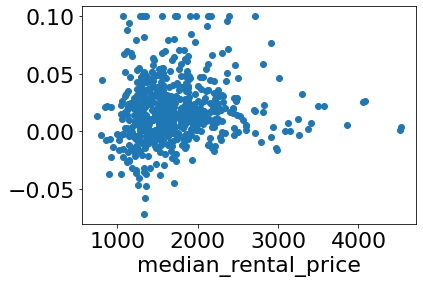

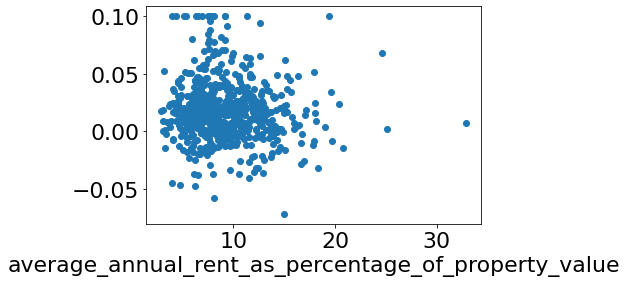

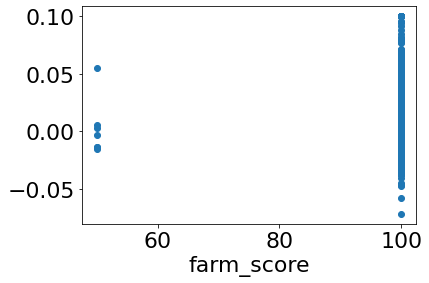

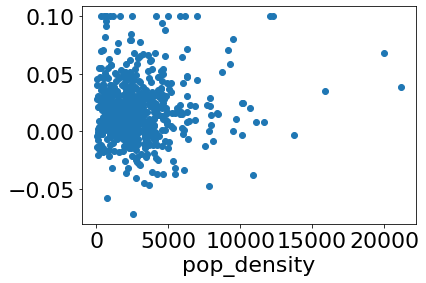

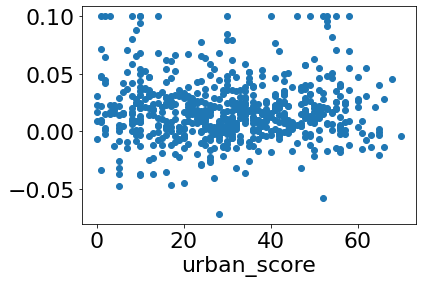

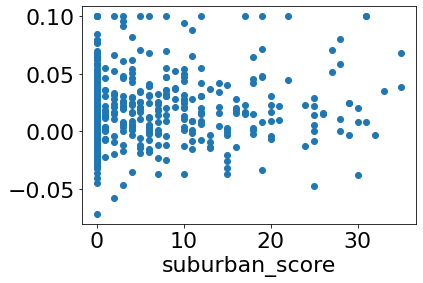

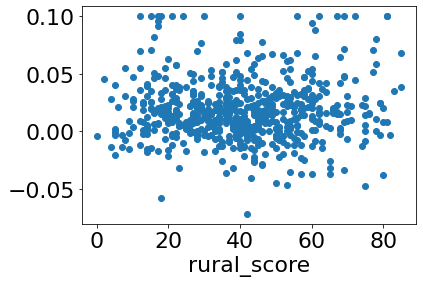

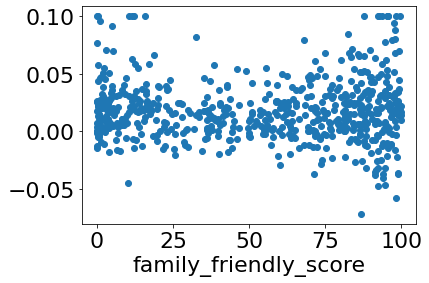

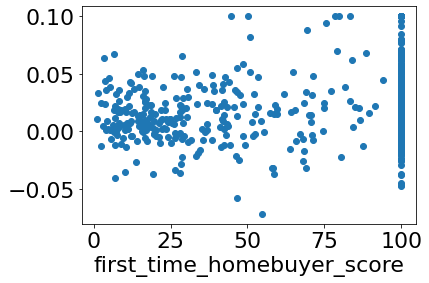

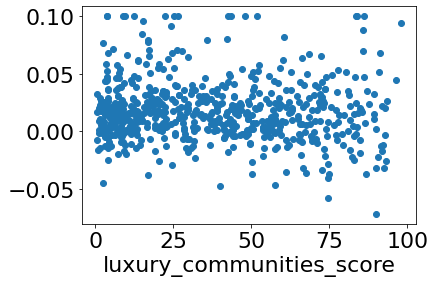

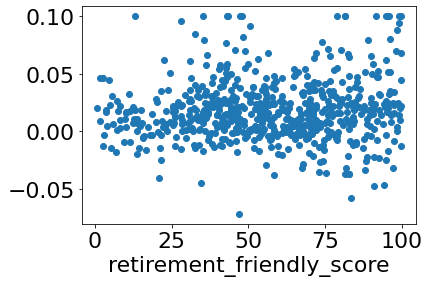

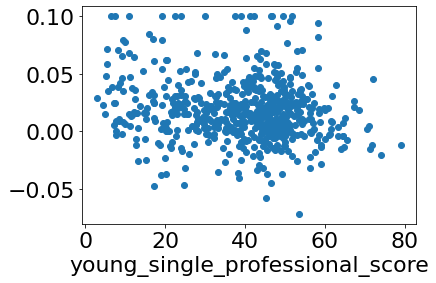

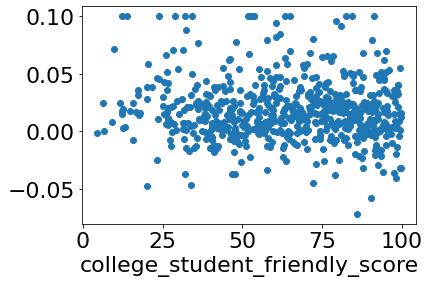

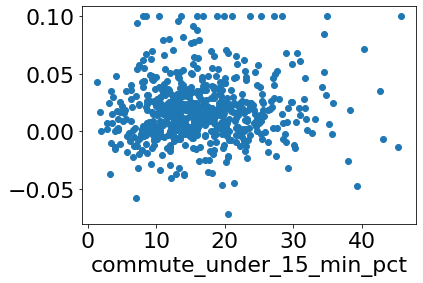

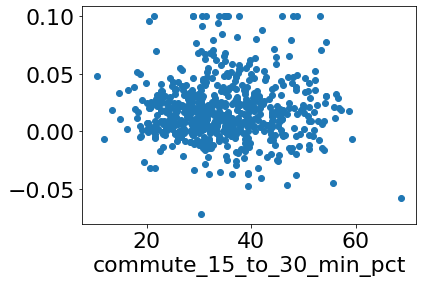

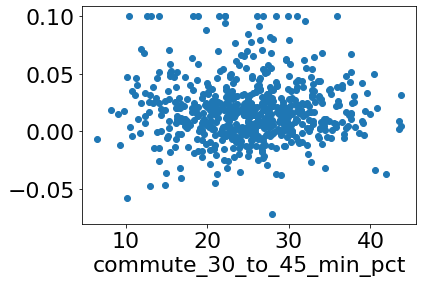

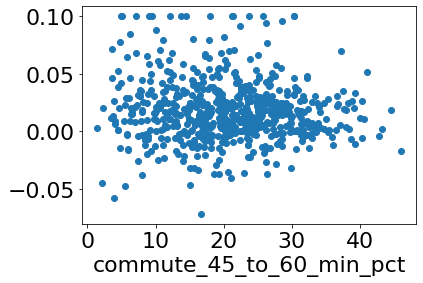

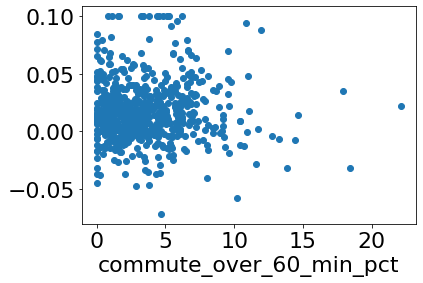

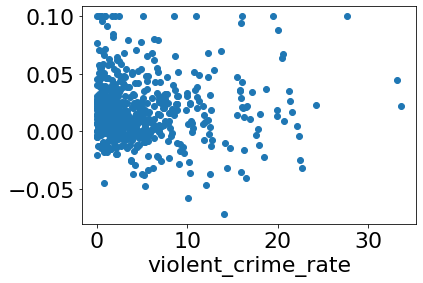

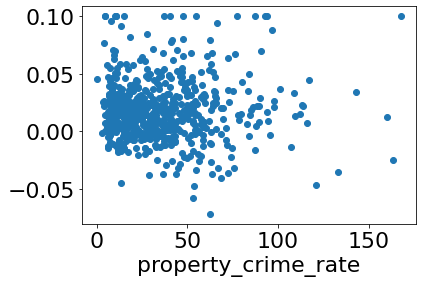

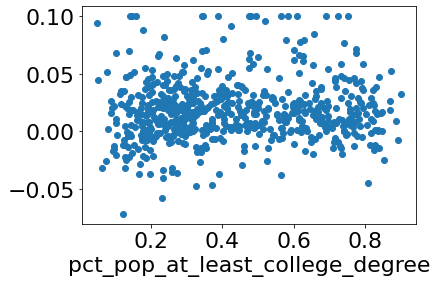

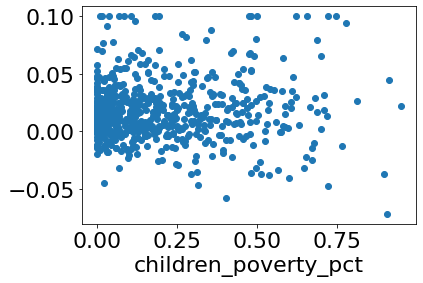

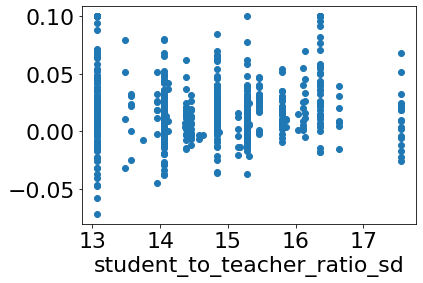

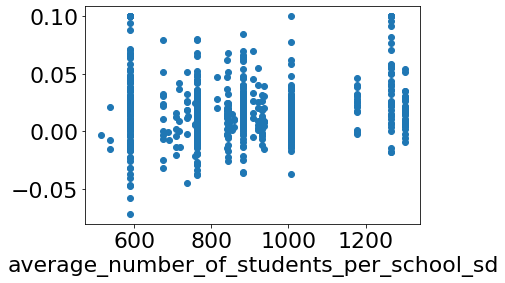

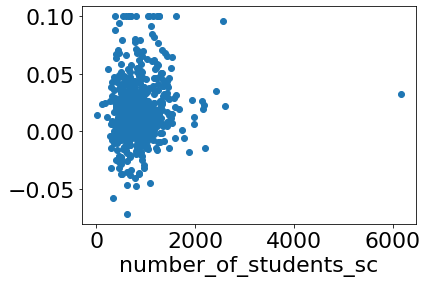

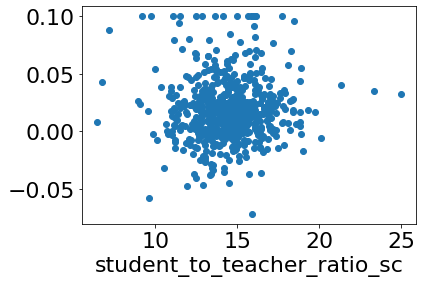

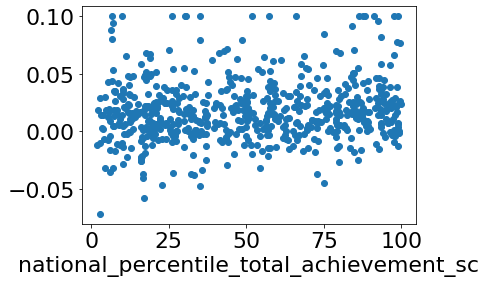

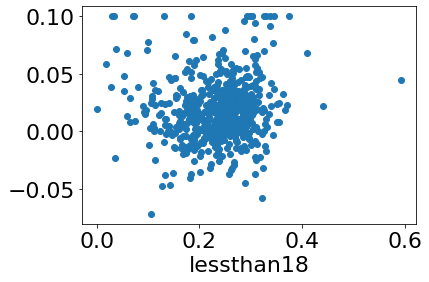

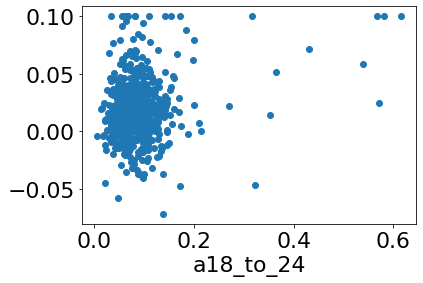

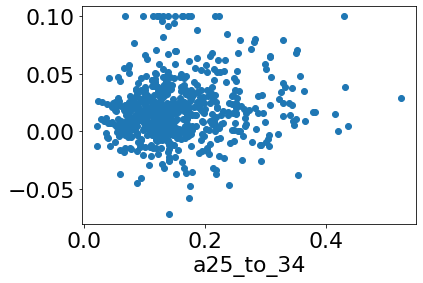

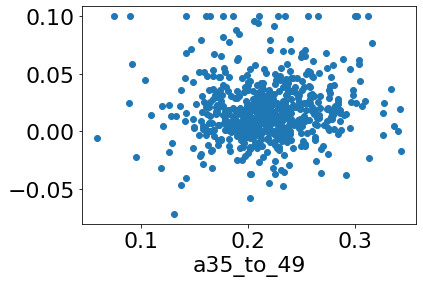

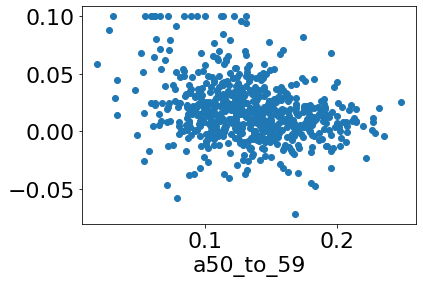

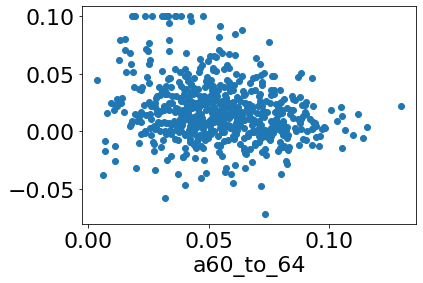

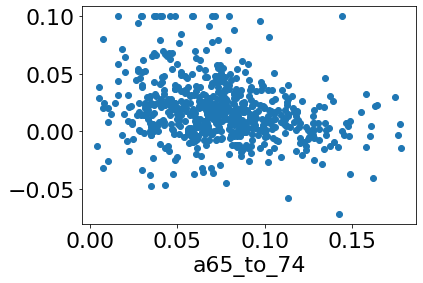

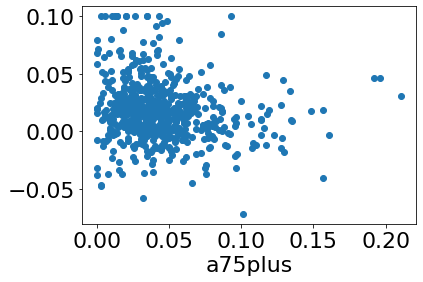

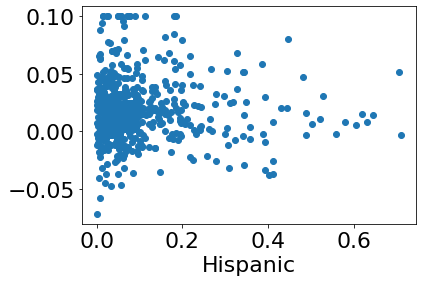

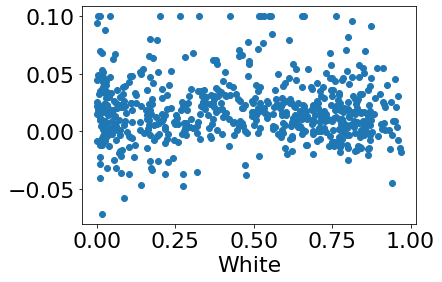

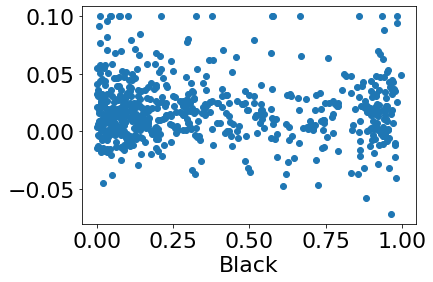

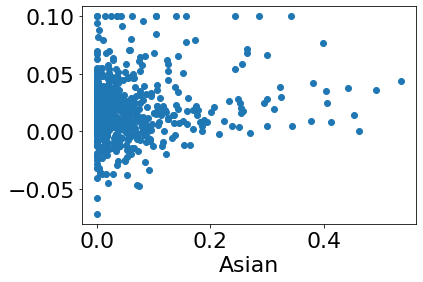

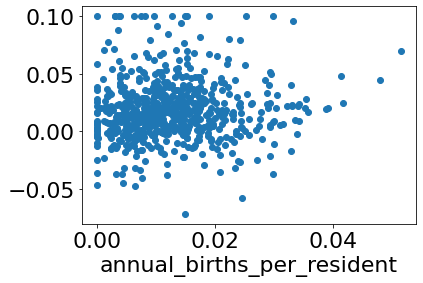

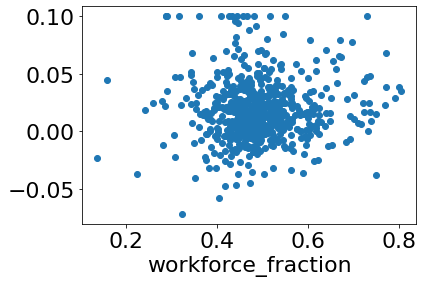

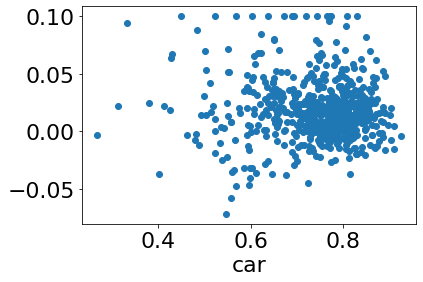

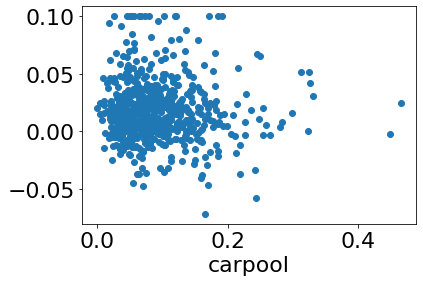

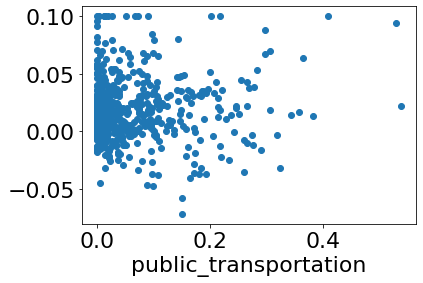

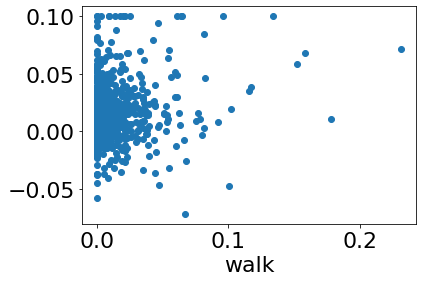

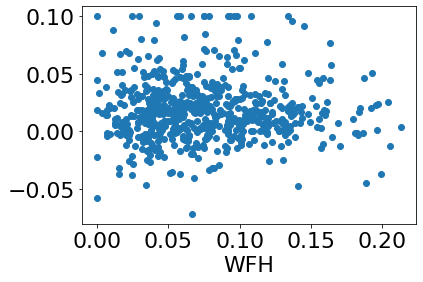

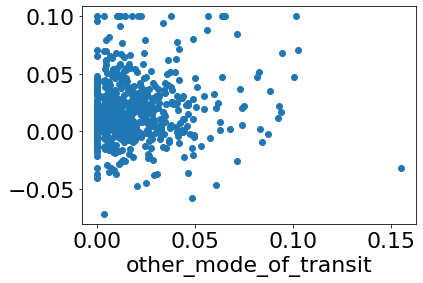

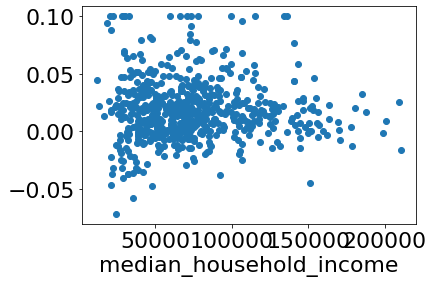

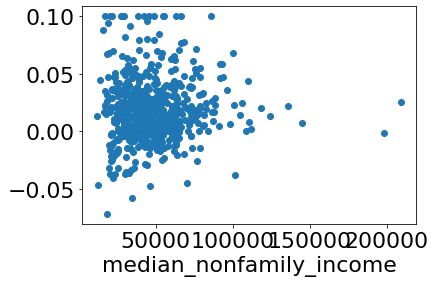

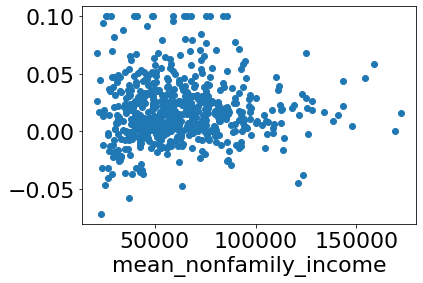

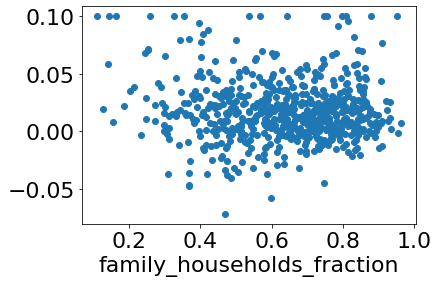

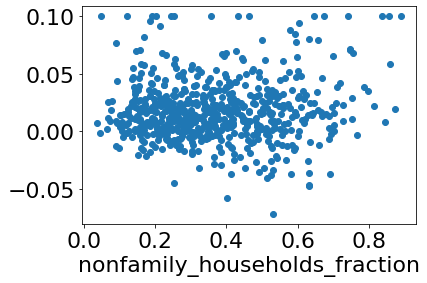

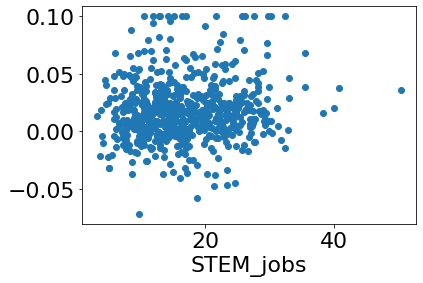

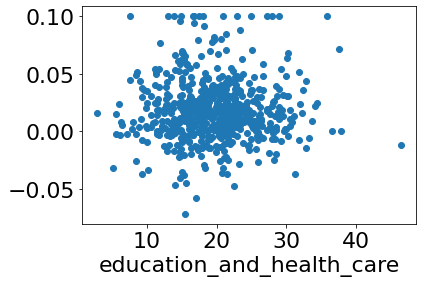

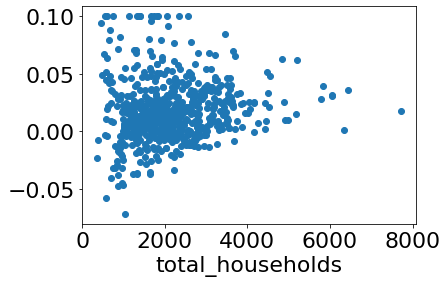

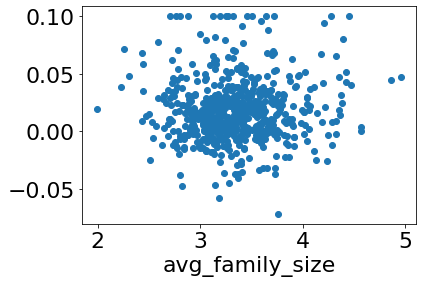

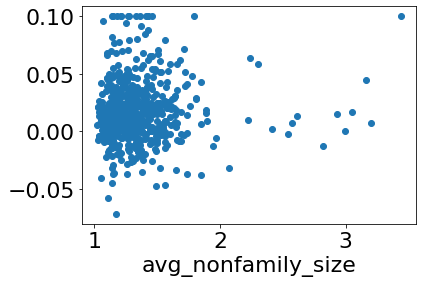

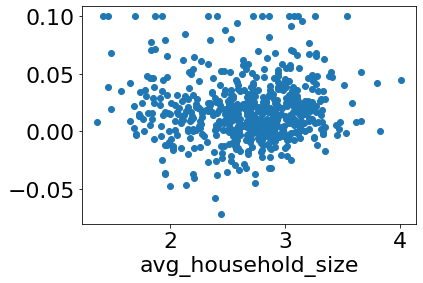

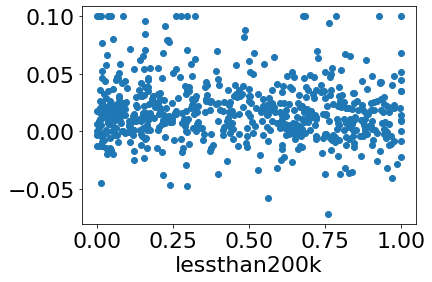

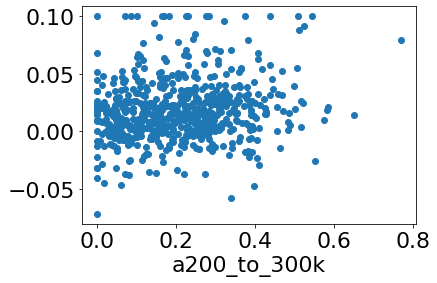

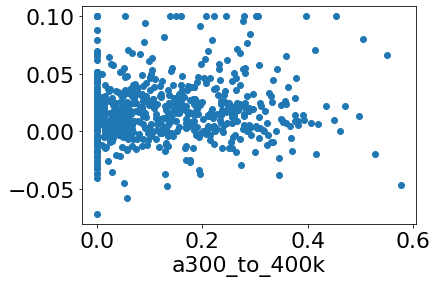

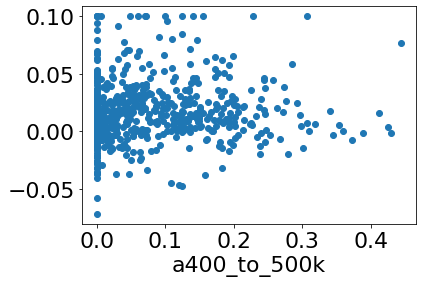

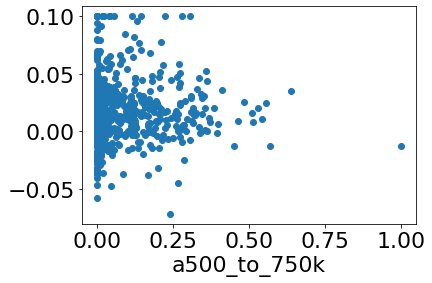

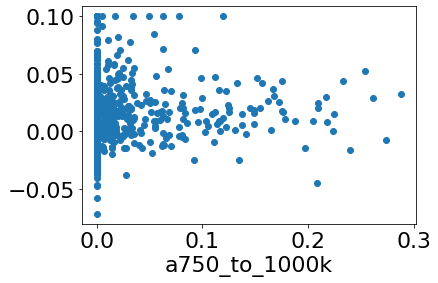

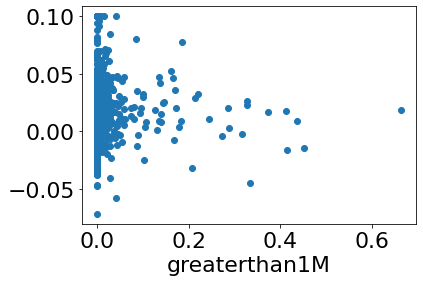

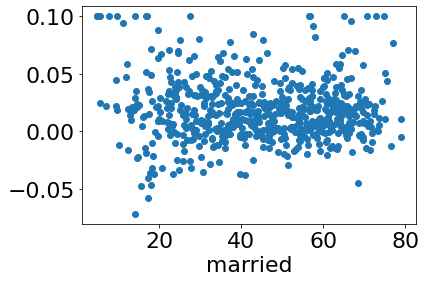

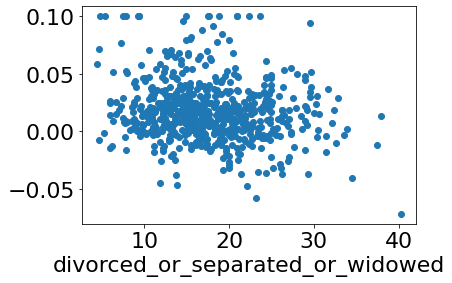

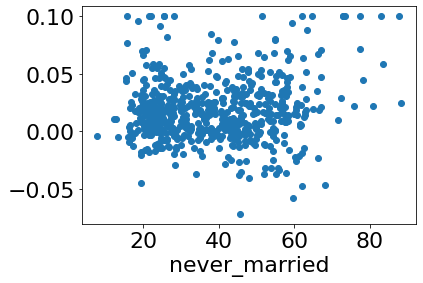

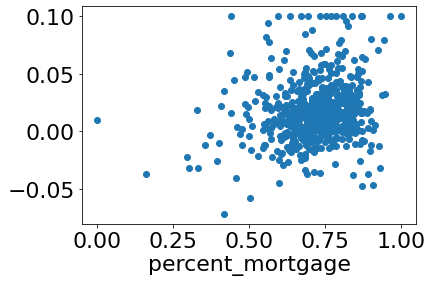

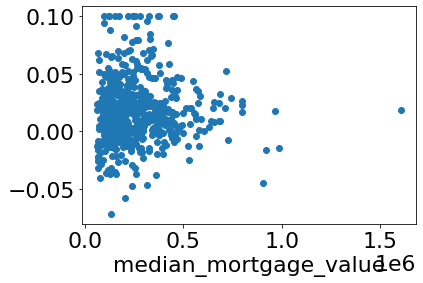

In [458]:
for col in X.columns:
    plt.scatter(X[col], y)
    plt.xlabel(col)
    plt.ylabel('')
    plt.show()

In [459]:
X.columns = ['a' + col if col[0].isdigit() else col for col in X.columns]
X.columns = (X.columns.str.replace('-', '_to_').str.replace('+', 'plus').str.replace('/', '_or_')
             .str.replace('&', '_and_'))

In [460]:
X_train = X
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)
train_df = X_train_normalized
train_df['pop_growth'] = y

In [461]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = -smf.ols(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [462]:
model = forward_selected(train_df, 'pop_growth')

In [463]:
selected_predictors = [x for x in model.params.index if x != 'Intercept']

In [464]:
X_train_selected = train_df[selected_predictors]

In [465]:
X_train_selected.shape

(630, 26)

In [466]:
resids = model.resid
preds = model.predict(X_train_selected)

In [467]:
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_external

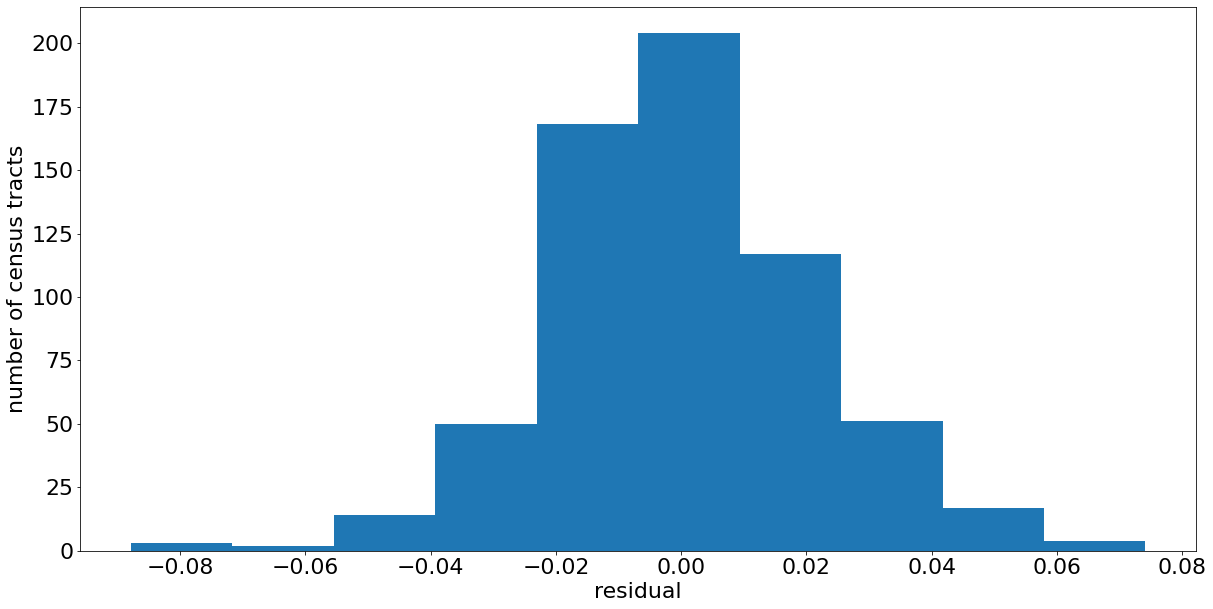

In [468]:
plt.figure(figsize=(20, 10))
plt.hist(resids)
plt.xlabel('residual')
plt.ylabel('number of census tracts')
plt.show()

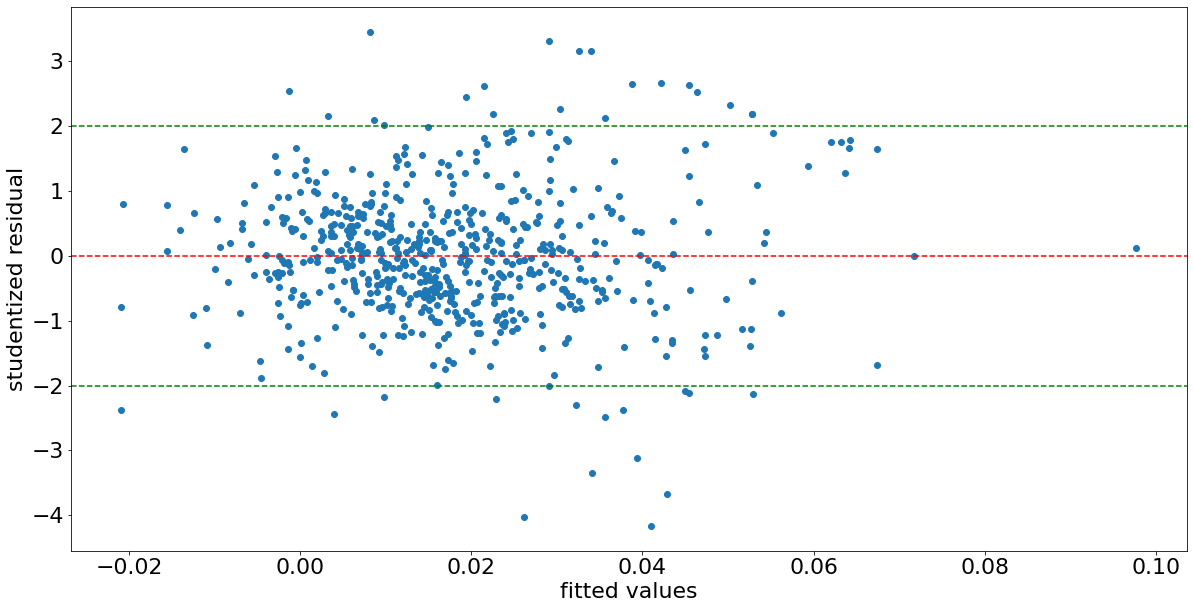

In [469]:
plt.figure(figsize=(20, 10))
plt.scatter(preds, studentized_residuals)
plt.xlabel('fitted values')
plt.ylabel('studentized residual')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')
plt.show()

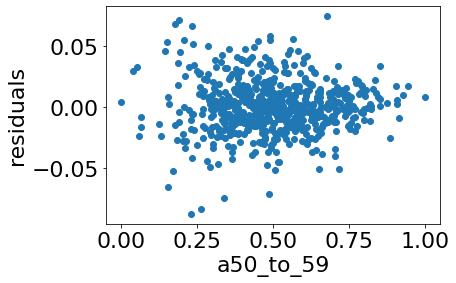

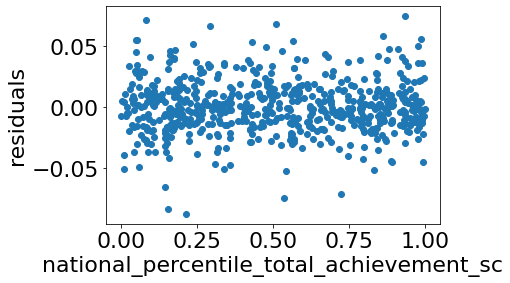

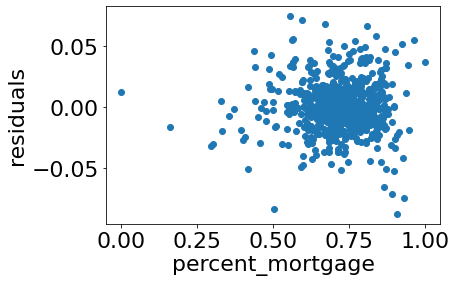

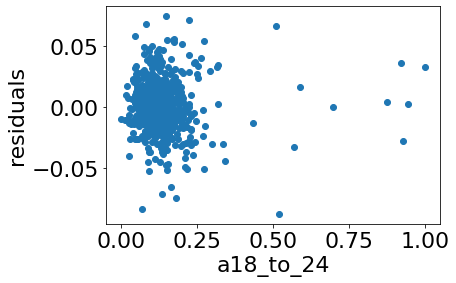

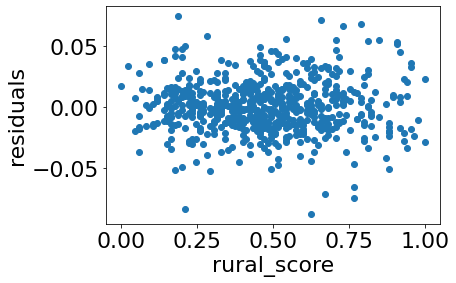

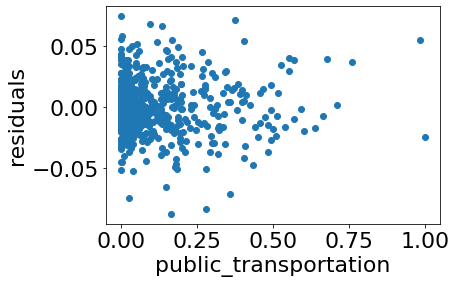

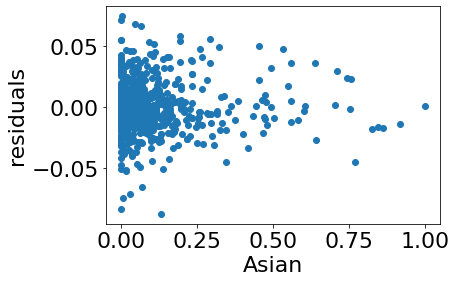

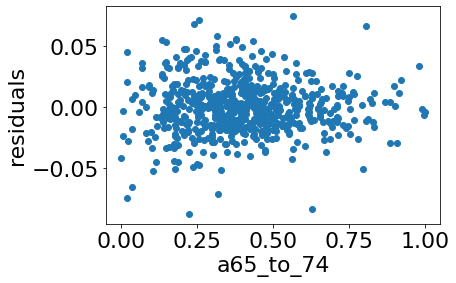

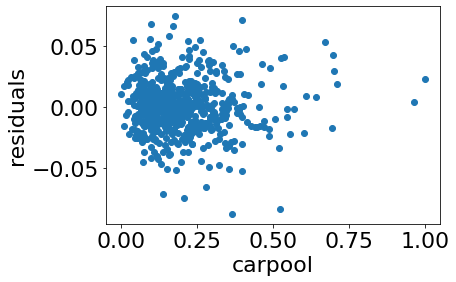

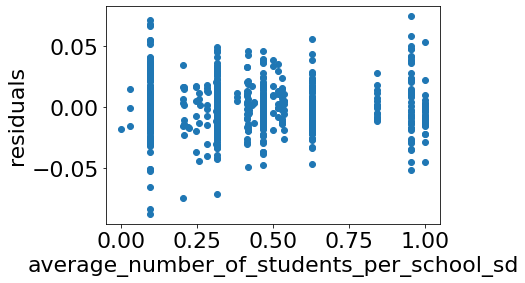

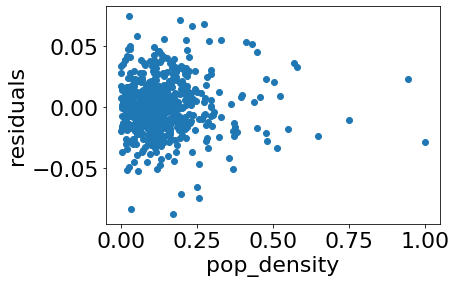

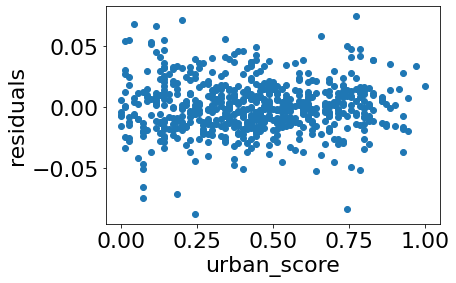

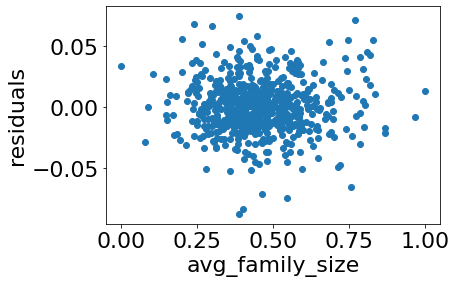

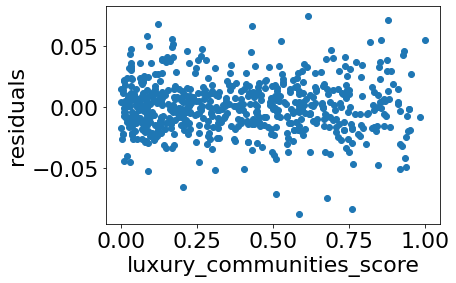

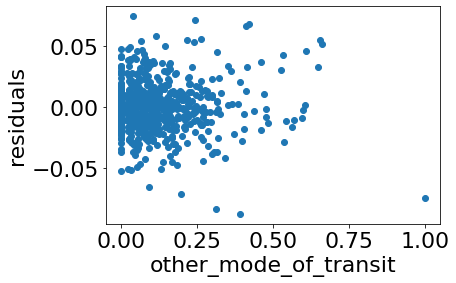

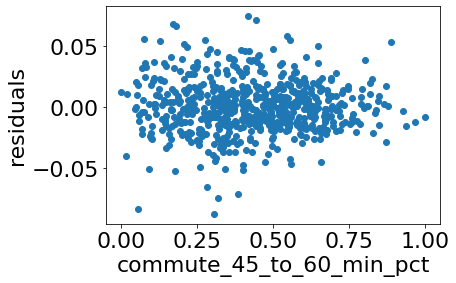

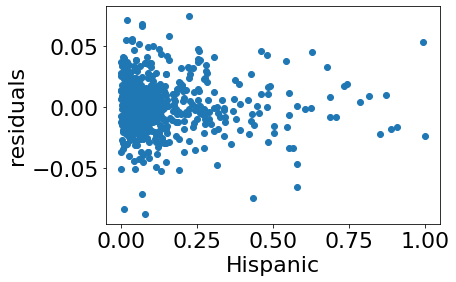

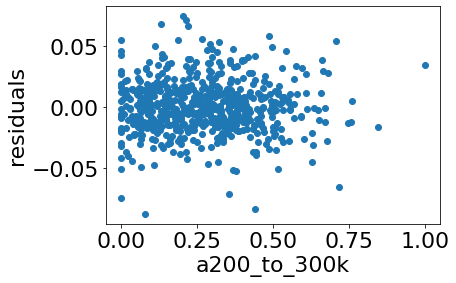

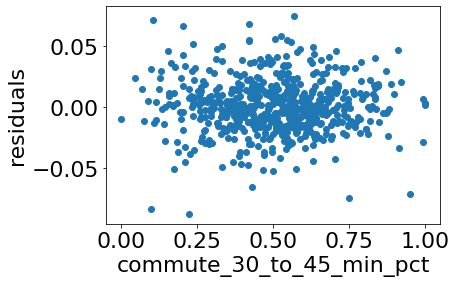

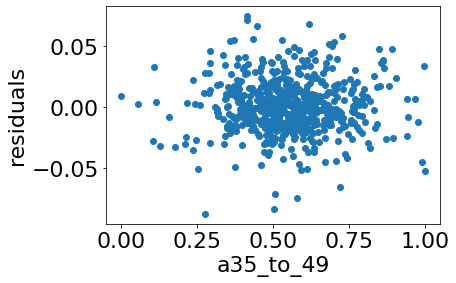

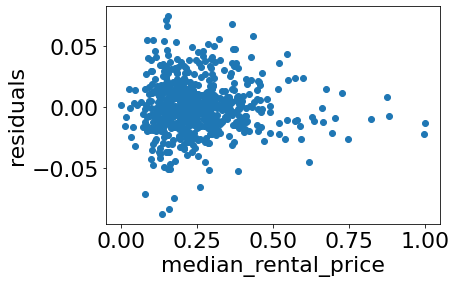

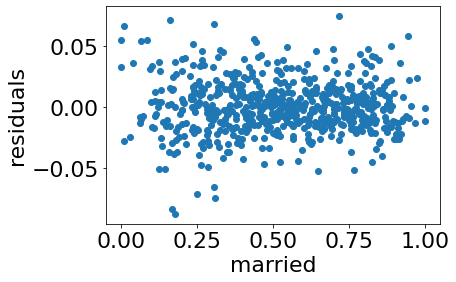

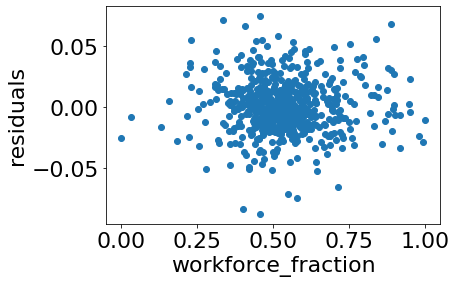

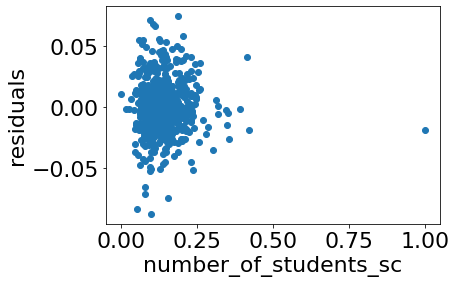

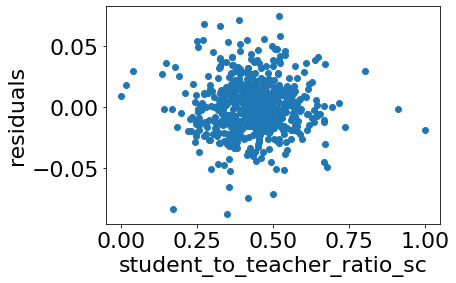

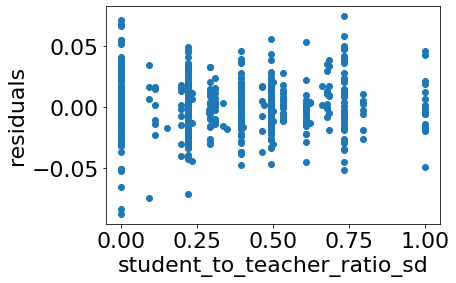

In [470]:
for col in X_train_selected.columns:
    plt.scatter(X_train_selected[col], resids)
    plt.xlabel(col)
    plt.ylabel('residuals')
    plt.show()

In [471]:
coefs = model.params
pvalues = model.pvalues.sort_values()

In [472]:
for variable in pvalues.index:
    if variable != 'Intercept':
        var = variable[1:] if (variable[0] == 'a' and variable[1].isdigit()) else variable
        print(f'{var} -- coef: {round(coefs[variable], 3)}, p-value: {round(pvalues[variable], 5)}\n')

50_to_59 -- coef: -0.053, p-value: 0.0

pop_density -- coef: 0.183, p-value: 0.0

rural_score -- coef: -0.296, p-value: 1e-05

public_transportation -- coef: 0.039, p-value: 8e-05

urban_score -- coef: -0.156, p-value: 0.00041

65_to_74 -- coef: -0.023, p-value: 0.00076

percent_mortgage -- coef: 0.034, p-value: 0.00117

other_mode_of_transit -- coef: 0.025, p-value: 0.00156

avg_family_size -- coef: 0.034, p-value: 0.00201

national_percentile_total_achievement_sc -- coef: 0.014, p-value: 0.00371

student_to_teacher_ratio_sc -- coef: -0.034, p-value: 0.00616

luxury_communities_score -- coef: -0.023, p-value: 0.00875

number_of_students_sc -- coef: 0.048, p-value: 0.01028

commute_30_to_45_min_pct -- coef: 0.013, p-value: 0.01479

Hispanic -- coef: -0.019, p-value: 0.01704

married -- coef: -0.022, p-value: 0.02423

commute_45_to_60_min_pct -- coef: -0.014, p-value: 0.02633

200_to_300k -- coef: 0.013, p-value: 0.0288

18_to_24 -- coef: 0.028, p-value: 0.03616

Asian -- coef: 0.015, p

In [473]:
print('MAE trained on entire dataset:', mean_absolute_error(preds, y))

MAE trained on entire dataset: 0.016260446089375956


In [474]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized = pd.DataFrame(X_train_normalized, index=X_train.index, columns=X_train.columns)

X_test_normalized = scaler.transform(X_test)
X_test_normalized = pd.DataFrame(X_test_normalized, index=X_test.index, columns=X_test.columns)

In [475]:
train_df = X_train_normalized
train_df['pop_growth'] = y_train

In [476]:
model = forward_selected(train_df, 'pop_growth')

In [477]:
selected_predictors = [x for x in model.params.index if x != 'Intercept']

In [478]:
X_train_selected = train_df[selected_predictors]

In [479]:
X_train_selected.shape

(504, 26)

In [480]:
train_preds = model.predict(X_train_selected)
test_preds = model.predict(X_test_normalized)

In [481]:
print('train MAE:', mean_absolute_error(train_preds, y_train))
print('test MAE:', mean_absolute_error(test_preds, y_test))

train MAE: 0.015829219176458922
test MAE: 0.018629907502176687


In [482]:
print('R^2:', model.rsquared)

R^2: 0.39420583515729224
